Environment Setup

In [1]:
%pip install numpy
%pip install pandas
%pip install scikit-learn
%pip install keras

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import sklearn
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
plt.rcParams['font.family'] = 'Arial'

In [3]:
# Load and inspect the stock prices dataset
prices_split_adjusted = pd.read_csv("data/prices-split-adjusted.csv", index_col=0)
print(prices_split_adjusted.info())
print(prices_split_adjusted.head())

<class 'pandas.core.frame.DataFrame'>
Index: 851264 entries, 2016-01-05 to 2016-12-30
Data columns (total 6 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   symbol  851264 non-null  object 
 1   open    851264 non-null  float64
 2   close   851264 non-null  float64
 3   low     851264 non-null  float64
 4   high    851264 non-null  float64
 5   volume  851264 non-null  float64
dtypes: float64(5), object(1)
memory usage: 45.5+ MB
None
           symbol        open       close         low        high     volume
date                                                                        
2016-01-05   WLTW  123.430000  125.839996  122.309998  126.250000  2163600.0
2016-01-06   WLTW  125.239998  119.980003  119.940002  125.540001  2386400.0
2016-01-07   WLTW  116.379997  114.949997  114.930000  119.739998  2489500.0
2016-01-08   WLTW  115.480003  116.620003  113.500000  117.440002  2006300.0
2016-01-11   WLTW  117.010002  114.970001  114.089996  117

In [4]:
prices_split_adjusted.head()

,symbol,open,close,low,high,volume
date,,,,,,
2016-01-05,WLTW,123.430000,125.839996,122.309998,126.250000,2163600.0
2016-01-06,WLTW,125.239998,119.980003,119.940002,125.540001,2386400.0
2016-01-07,WLTW,116.379997,114.949997,114.930000,119.739998,2489500.0
2016-01-08,WLTW,115.480003,116.620003,113.500000,117.440002,2006300.0
2016-01-11,WLTW,117.010002,114.970001,114.089996,117.330002,1408600.0


In [5]:
prices_split_adjusted.describe()

,open,close,low,high,volume
count,851264.000000,851264.000000,851264.000000,851264.000000,8.512640e+05
mean,64.993618,65.011913,64.336541,65.639748,5.415113e+06
std,75.203893,75.201216,74.459518,75.906861,1.249468e+07
min,1.660000,1.590000,1.500000,1.810000,0.000000e+00
25%,31.270000,31.292776,30.940001,31.620001,1.221500e+06
50%,48.459999,48.480000,47.970001,48.959999,2.476250e+06
75%,75.120003,75.139999,74.400002,75.849998,5.222500e+06
max,1584.439941,1578.130005,1549.939941,1600.930054,8.596434e+08


Example stock graph for WLTW

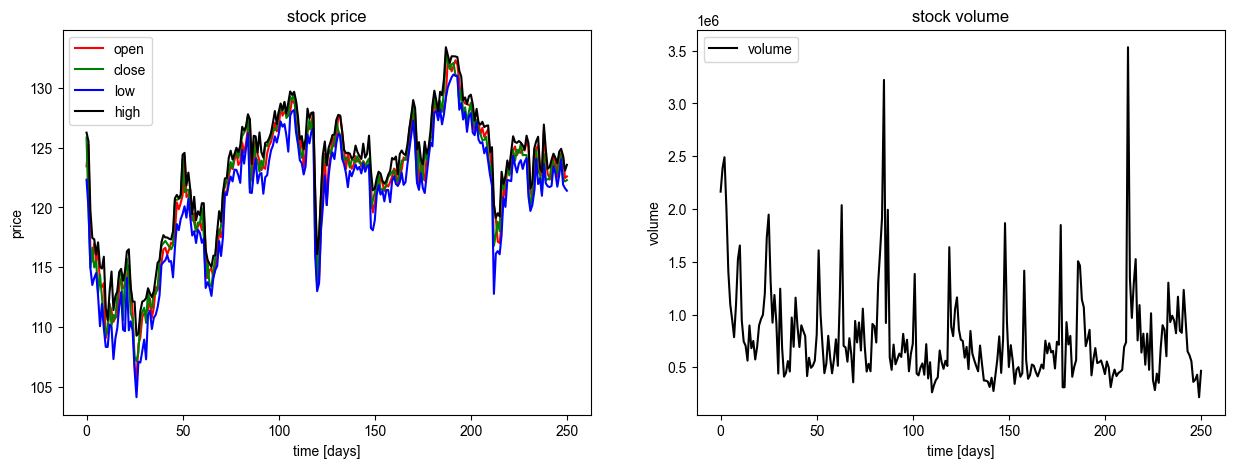

In [6]:
plt.figure(figsize=(15, 5))
plt.subplot(1,2,1)
plt.plot(prices_split_adjusted[prices_split_adjusted.symbol == 'WLTW'].open.values, color='red', label='open')
plt.plot(prices_split_adjusted[prices_split_adjusted.symbol == 'WLTW'].close.values, color='green', label='close')
plt.plot(prices_split_adjusted[prices_split_adjusted.symbol == 'WLTW'].low.values, color='blue', label='low')
plt.plot(prices_split_adjusted[prices_split_adjusted.symbol == 'WLTW'].high.values, color='black', label='high')
plt.title('stock price')
plt.xlabel('time [days]')
plt.ylabel('price')
plt.legend(loc='best')

plt.subplot(1,2,2)
plt.plot(prices_split_adjusted[prices_split_adjusted.symbol == 'WLTW'].volume.values, color='black', label='volume')
plt.title('stock volume')
plt.xlabel('time [days]')
plt.ylabel('volume')
plt.legend(loc='best')

Preprocessing Data

 5-day and 10-day simple moving averages (SMAs) for the closing price of a chosen stock.

 A simple moving average crossover system can help you evaluate potential entry and exit points in a trading strategy
 
 
https://www.schwab.com/learn/story/understanding-simple-moving-average-crossovers#:~:text=A%20simple%20moving%20average%20(SMA,over%20the%20previous%2020%20days

In [7]:
# Demonstrate with one stock symbol
selected_symbol = prices_split_adjusted['symbol'].unique()[0]  # Example: 'WLTW'
selected_stock_data = prices_split_adjusted[prices_split_adjusted['symbol'] == selected_symbol]

# Prepare the data for the selected WLTW
data = prices_split_adjusted.loc[prices_split_adjusted['symbol'] == selected_symbol].copy()
data.loc[:, 'SMA_5'] = data['close'].rolling(window=5).mean()
data.loc[:, 'SMA_10'] = data['close'].rolling(window=10).mean()
data.dropna(inplace=True)

In [8]:
from sklearn.model_selection import KFold

features = ['open', 'low', 'high', 'volume', 'SMA_5', 'SMA_10']
X = data[features].values
y = data['close'].values

min_vals = X.min(axis=0)
max_vals = X.max(axis=0)

ranges = max_vals - min_vals

ranges[ranges == 0] = 1

X = (X - min_vals) / ranges
y_min = np.min(y)
y_max = np.max(y)
y = (y - y_min) / (y_max - y_min)

# Split the data into folds
kf = KFold(n_splits=10, shuffle=False)

y_pred_all = []
y_test_all = []
# Iterate over the folds
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    model = LinearRegression()
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    y_pred_all.extend(y_pred)
    y_test_all.extend(y_test)

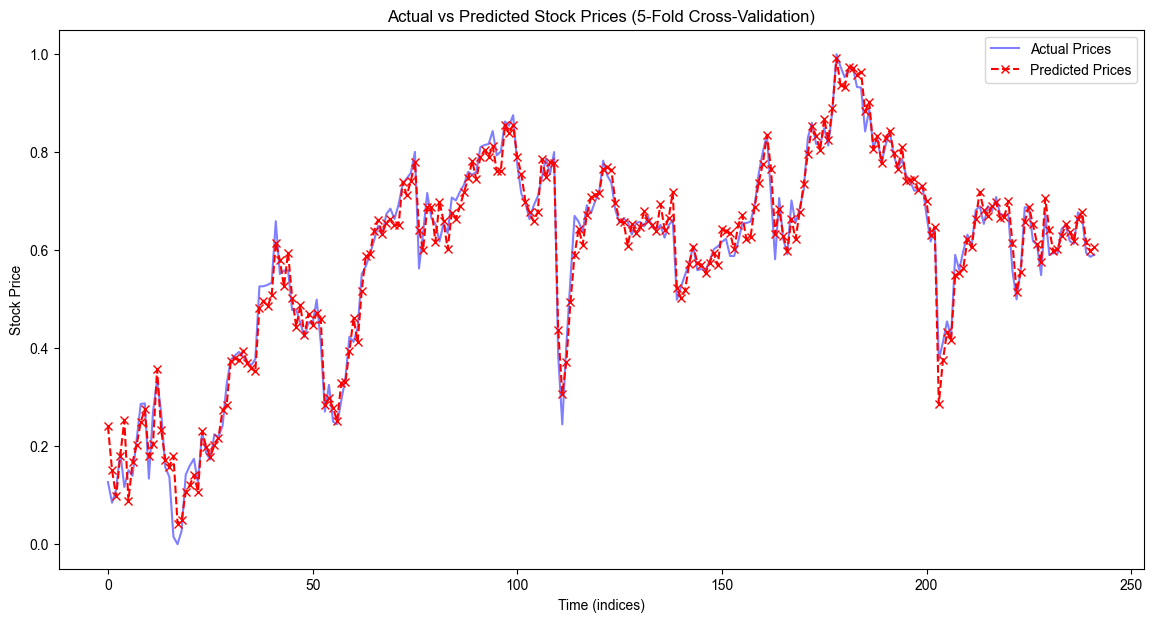

In [9]:
plt.figure(figsize=(14, 7))
plt.plot(np.arange(len(y)), y, label='Actual Prices', color='blue', alpha=0.5)
plt.plot(np.arange(len(y_pred_all)), y_pred_all, label='Predicted Prices', color='red', linestyle='--', marker='x')

plt.title('Actual vs Predicted Stock Prices (5-Fold Cross-Validation)')
plt.xlabel('Time (indices)')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [10]:
from sklearn import metrics
print('Model accuracy (%)')

y_true = y
y_pred = y_pred_all

print((1-(metrics.mean_absolute_error(y_true, y_pred)/y_true.mean()))*100)
print('')
print('Prediction performance')
print('MAE in %', (metrics.mean_absolute_error(y_true, y_pred)/y_true.mean())*100)
print('MSE', metrics.mean_squared_error(y_true, y_pred))
print('RMSE',np.sqrt(metrics.mean_squared_error(y_true, y_pred)))
print('R2', metrics.r2_score(y_true, y_pred))

Model accuracy (%)
95.94684192008927

Prediction performance
MAE in % 4.053158079910731
MSE 0.0010169781772846641
RMSE 0.03189009528497311
R2 0.9766804987041898




Cross Validation on Time Series:

https://medium.com/@soumyachess1496/cross-validation-in-time-series-566ae4981ce4

RMSE represents the standard deviation of the prediction errors, indicating on average how much the model's predictions deviate from the actual stock prices.



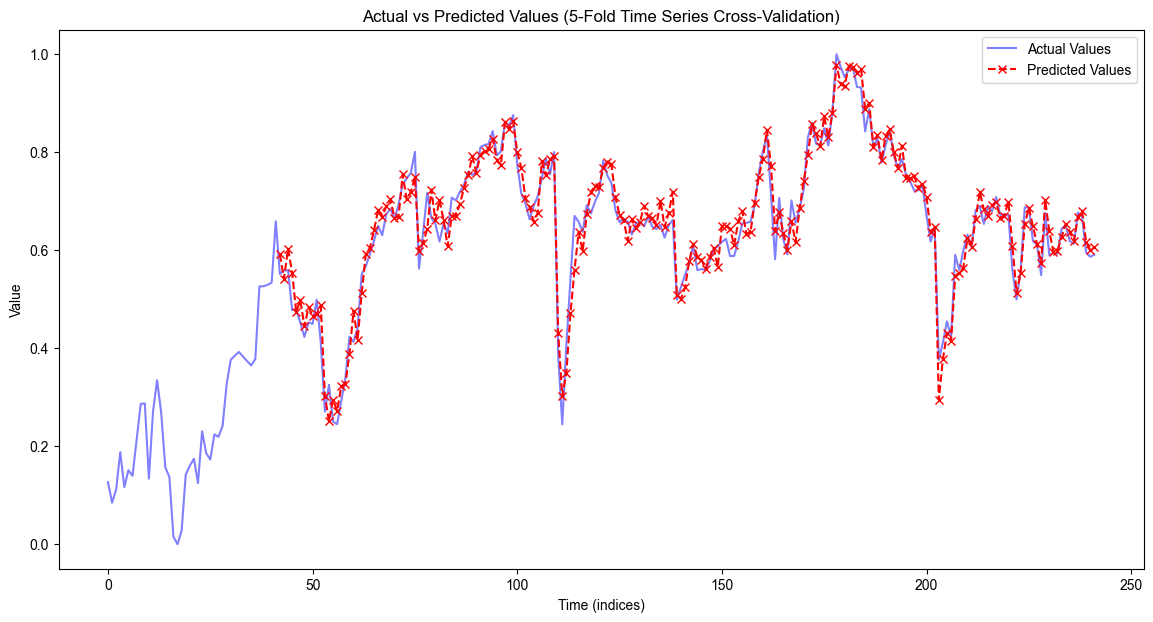

Model accuracy (%)
96.2748876029055

Prediction performance
MAE in % 3.725112397094515
MSE 0.0009683510498861246
RMSE 0.031118339446154972
R2 0.950864775345505


In [11]:
# Time Series Cross-Validation
n_split = 5
tscv = TimeSeriesSplit(n_splits=n_split)
mae_scores = []
rmse_scores = []

y_pred_cv = []
for train_idx, test_idx in tscv.split(X):
    model_cv = LinearRegression()
    model_cv.fit(X[train_idx], y[train_idx])
    y_pred = model_cv.predict(X[test_idx])
    y_pred_cv.extend(y_pred)

plt.figure(figsize=(14, 7))
plt.plot(np.arange(len(y)), y, label='Actual Values', color='blue', alpha=0.5)

offset = int(len(y) - len(y_pred_cv))
plt.plot(np.arange(len(y_pred_cv)) + offset, y_pred_cv, label='Predicted Values', color='red', linestyle='--', marker='x')

plt.title('Actual vs Predicted Values (5-Fold Time Series Cross-Validation)')
plt.xlabel('Time (indices)')
plt.ylabel('Value')
plt.legend()
plt.show()

print('Model accuracy (%)')

y_true = y[offset:]
y_pred = y_pred_cv

print((1-(metrics.mean_absolute_error(y_true, y_pred)/y_true.mean()))*100)
print('')
print('Prediction performance')
print('MAE in %', (metrics.mean_absolute_error(y_true, y_pred)/y_true.mean())*100)
print('MSE', metrics.mean_squared_error(y_true, y_pred))
print('RMSE',np.sqrt(metrics.mean_squared_error(y_true, y_pred)))
print('R2', metrics.r2_score(y_true, y_pred))

Test RMSE: 0.05816546146599302


/home/bacon/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


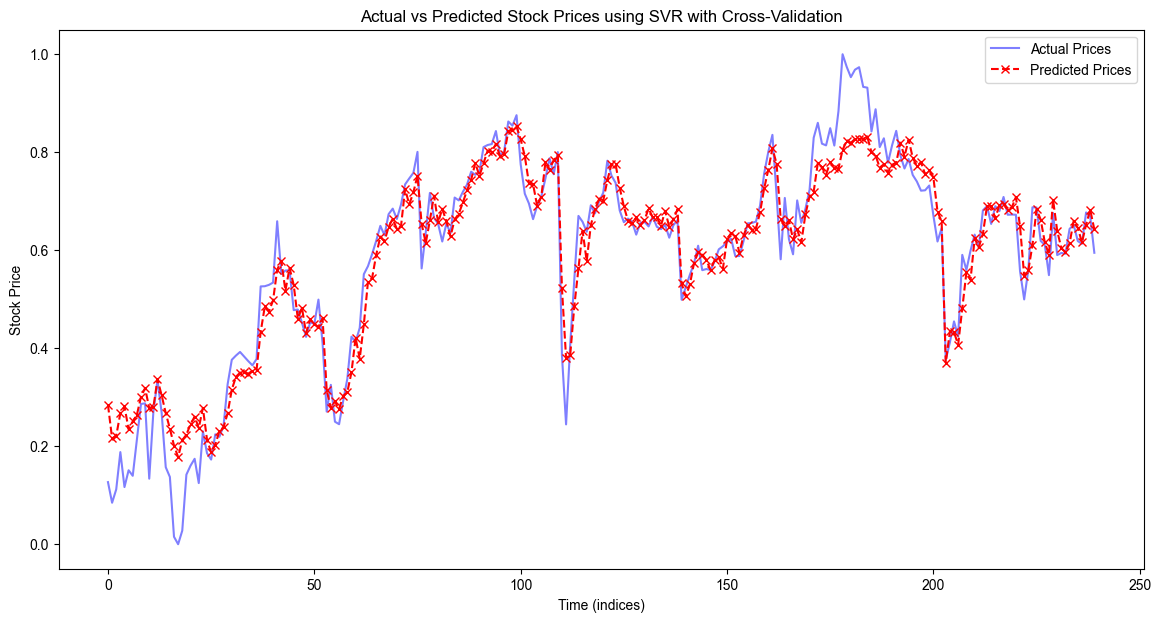

In [12]:
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.svm import SVR

model = SVR(kernel='rbf', gamma='auto', C=15)

kf = KFold(n_splits=10)

temp_y = y[:240]
temp_X = X[:240]
train_rmse_list = []
test_rmse_list = []

all_y_pred = []

for train_index, test_index in kf.split(temp_X):
    X_train, X_test = temp_X[train_index], temp_X[test_index]
    y_train, y_test = temp_y[train_index], temp_y[test_index]
    
    model.fit(X_train, y_train)
    
    y_pred_fold = model.predict(X_test)
    
    all_y_pred.extend(y_pred_fold)

time_indices = np.arange(len(temp_y))
plt.figure(figsize=(14, 7))
plt.plot(time_indices, temp_y, label='Actual Prices', color='blue', alpha=0.5)
plt.plot(time_indices, all_y_pred, label='Predicted Prices', color='red', linestyle='--', marker='x')
# train_rmse = mean_squared_error(y_train, all_y_pred, squared=False)
# print("Train RMSE:", train_rmse)

test_predictions = model.predict(X_train)

test_rmse = mean_squared_error(temp_y, all_y_pred, squared=False)
print("Test RMSE:", test_rmse)

# print("predictions:", test_predictions)

plt.title('Actual vs Predicted Stock Prices using SVR with Cross-Validation')
plt.xlabel('Time (indices)')
plt.ylabel('Stock Price')
plt.legend()
plt.show()


Support Vector Machine

In [13]:

from sklearn import metrics
print('Model accuracy (%)')

y_true=y[:240]
print((1-(metrics.mean_absolute_error(y_true, all_y_pred)/y_true.mean()))*100)
print('')
print('Prediction performance')
print('MAE in %', (metrics.mean_absolute_error(y_true, all_y_pred)/y_true.mean())*100)
print('MSE', metrics.mean_squared_error(y_true, all_y_pred))
print('RMSE',np.sqrt(metrics.mean_squared_error(y_true, all_y_pred)))
print('R2', metrics.r2_score(y_true, all_y_pred))

Model accuracy (%)
92.79243132019221

Prediction performance
MAE in % 7.2075686798077925
MSE 0.0033832209075519187
RMSE 0.05816546146599302
R2 0.9230631525310278


LSTM Algorithm

In [14]:
from sklearn.preprocessing import MinMaxScaler


features_scaler = MinMaxScaler()
scaled_train = features_scaler.fit_transform(X)

# Scale the target variable separately if needed
target_scaler = MinMaxScaler()
scaled_test = target_scaler.fit_transform(y.reshape(-1, 1))

In [15]:
def timeseries_preprocessing(scaled_train, scaled_test, lags):
    X,Y = [],[]
    for t in range(len(scaled_train)-lags-1):
        X.append(scaled_train[t:(t+lags),0])
        Y.append(scaled_train[(t+lags),0])
    
    Z,W = [],[]
    for t in range(len(scaled_test)-lags-1):
        Z.append(scaled_test[t:(t+lags),0])
        W.append(scaled_test[(t+lags),0])
        
    X_train, Y_train, X_test, Y_test=np.array(X), np.array(Y), np.array(Z),np.array(W)
    
    X_train = X_train.reshape((X_train.shape[0],X_train.shape[1],1))
    X_test = X_test.reshape((X_test.shape[0],X_test.shape[1],1))
    
    return X_train, Y_train, X_test, Y_test

In [16]:
X_train, Y_train, X_test,Y_test=timeseries_preprocessing(scaled_train, scaled_test, 10)

In [17]:
import matplotlib.pyplot as plt
import os 
os.environ["KERAS_BACKEND"] = "tensorflow" 
import keras
from keras.models import Sequential
from keras.optimizers import Adam
from keras import layers
from keras.layers import Dense, LSTM

kf = KFold(n_splits=5, shuffle=False)

y_pred_all = []
y_test_all = []
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    print(y_test)
    print(y_train)
    LSTM_model = Sequential()
    LSTM_model.add(LSTM(512,input_shape=(X_train.shape[1],1)))
    LSTM_model.add(Dense(1))
    LSTM_model.compile(optimizer='adam',loss='mse')

    history = LSTM_model.fit(x=X_train,y=y_train,epochs=100,validation_data=(X_test,y_test),shuffle=False)

    y_pred = model.predict(X_test)

    y_pred_all.extend(y_pred)
    y_test_all.extend(y_test)

# LSTM_model = Sequential()
# LSTM_model.add(LSTM(256,input_shape=(X_train.shape[1],1)))
# LSTM_model.add(Dense(1))
# LSTM_model.compile(optimizer='adam',loss='mse')

# history = LSTM_model.fit(x=X_train,y=Y_train,epochs=100,validation_data=(X_test,Y_test),shuffle=False)



2024-04-23 18:22:28.924727: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-23 18:22:28.929120: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-23 18:22:28.967614: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-23 18:22:29.931680: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


[0.12675504 0.0846336  0.11193456 0.18798747 0.11661487 0.15093611
 0.13962562 0.21255864 0.28627153 0.28744154 0.13377535 0.26989096
 0.33463337 0.26872068 0.15717652 0.13728565 0.0152106  0.
 0.02769106 0.14196564 0.16029641 0.17433696 0.12480515 0.23049931
 0.18564745 0.1727769  0.22425891 0.21918882 0.24141971 0.32683318
 0.37636503 0.38494541 0.39235578 0.38299522 0.37363492 0.36505454
 0.37792513 0.52613114 0.52652092 0.52925103 0.53393133 0.65912626
 0.55148191 0.55850219 0.55928237 0.47776898 0.4789393  0.45202811
 0.42316705]
[0.45280803 0.44968814 0.49921995 0.41029649 0.27067087 0.32527308
 0.25000009 0.24493    0.29290171 0.33775357 0.42355687 0.41302656
 0.44149754 0.55109209 0.56747266 0.59204356 0.6193448  0.64976597
 0.63065529 0.67355695 0.6848674  0.66380657 0.69305773 0.73439925
 0.74648966 0.75780014 0.80070208 0.5627924  0.63611547 0.71684867
 0.66614654 0.65366605 0.6177847  0.65444627 0.6349455  0.70748811
 0.70163811 0.71918869 0.73400916 0.76014043 0.75390003 0

2024-04-23 18:22:30.752749: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-23 18:22:30.753193: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
/home/bacon/.local/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - loss: 0.2309 - val_loss: 0.0451
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0290 - val_loss: 0.0083
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0152 - val_loss: 0.0224
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0117 - val_loss: 0.0071
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0083 - val_loss: 0.0137
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0064 - val_loss: 0.0081
Epoch 7/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0057 - val_loss: 0.0106
Epoch 8/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0048 - val_loss: 0.0081
Epoch 9/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0048 - val_loss: 0.0092
Epoch 10/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0044 - val_loss: 0.0073
Epoch 11/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0044 - val_loss: 0.0079
Epoch 12/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0042 - val_lo

/home/bacon/.local/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - loss: 0.0960 - val_loss: 0.0330
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0213 - val_loss: 0.0120
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0059 - val_loss: 0.0074
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0080 - val_loss: 0.0052
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.0051 - val_loss: 0.0048
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.0052 - val_loss: 0.0044
Epoch 7/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.0043 - val_loss: 0.0043
Epoch 8/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0041 - val_loss: 0.0043
Epoch 9/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.0038 - val_loss: 0.0043
Epoch 10/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0038 - val_loss: 0.0042
Epoch 11/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0037 - val_loss: 0.0042
Epoch 12/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0037 - val_loss: 0.0041
E

/home/bacon/.local/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - loss: 0.0842 - val_loss: 0.0372
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0219 - val_loss: 0.0119
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.0055 - val_loss: 0.0065
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.0078 - val_loss: 0.0045
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 0.0050 - val_loss: 0.0038
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0051 - val_loss: 0.0036
Epoch 7/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.0043 - val_loss: 0.0032
Epoch 8/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0041 - val_loss: 0.0032
Epoch 9/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0040 - val_loss: 0.0029
Epoch 10/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.0038 - val_loss: 0.0029
Epoch 11/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0038 - val_loss: 0.0029
Epoch 12/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0037 - val_loss: 0.0028
E

/home/bacon/.local/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - loss: 0.0833 - val_loss: 0.0281
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.0210 - val_loss: 0.0184
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0062 - val_loss: 0.0029
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0086 - val_loss: 0.0048
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0054 - val_loss: 0.0014
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0057 - val_loss: 0.0023
Epoch 7/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0046 - val_loss: 0.0014
Epoch 8/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0044 - val_loss: 0.0016
Epoch 9/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0041 - val_loss: 0.0015
Epoch 10/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0040 - val_loss: 0.0015
Epoch 11/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0039 - val_loss: 0.0015
Epoch 12/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0039 - val_loss: 0.0015
E

/home/bacon/.local/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 108ms/step - loss: 0.0820 - val_loss: 0.0284
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.0212 - val_loss: 0.0053
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.0066 - val_loss: 0.0065
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 0.0096 - val_loss: 0.0041
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 0.0067 - val_loss: 0.0042
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.0060 - val_loss: 0.0051
Epoch 7/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.0057 - val_loss: 0.0036
Epoch 8/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0043 - val_loss: 0.0052
Epoch 9/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.0043 - val_loss: 0.0034
Epoch 10/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.0038 - val_loss: 0.0039
Epoch 11/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0037 - val_loss: 0.0036
Epoch 12/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0036 - val_l

Evaluating the model

Text(0.5, 1.0, 'Model fitting performance')

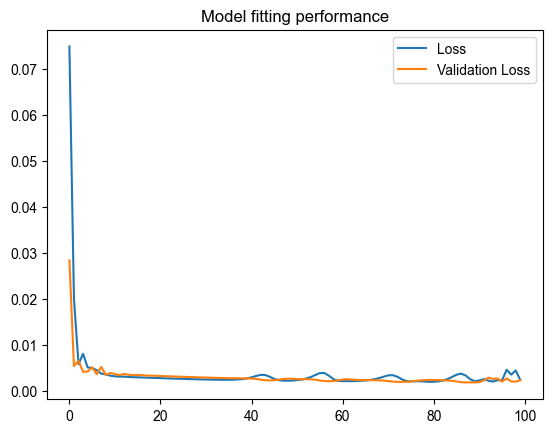

In [18]:
axes=plt.axes()
axes.plot(pd.DataFrame(LSTM_model.history.history)['loss'], label='Loss')
axes.plot(pd.DataFrame(LSTM_model.history.history)['val_loss'], label='Validation Loss')
axes.legend(loc=0)
axes.set_title('Model fitting performance')

In [19]:
Y_predicted= LSTM_model.predict(X_test)
Y_true=Y_test

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


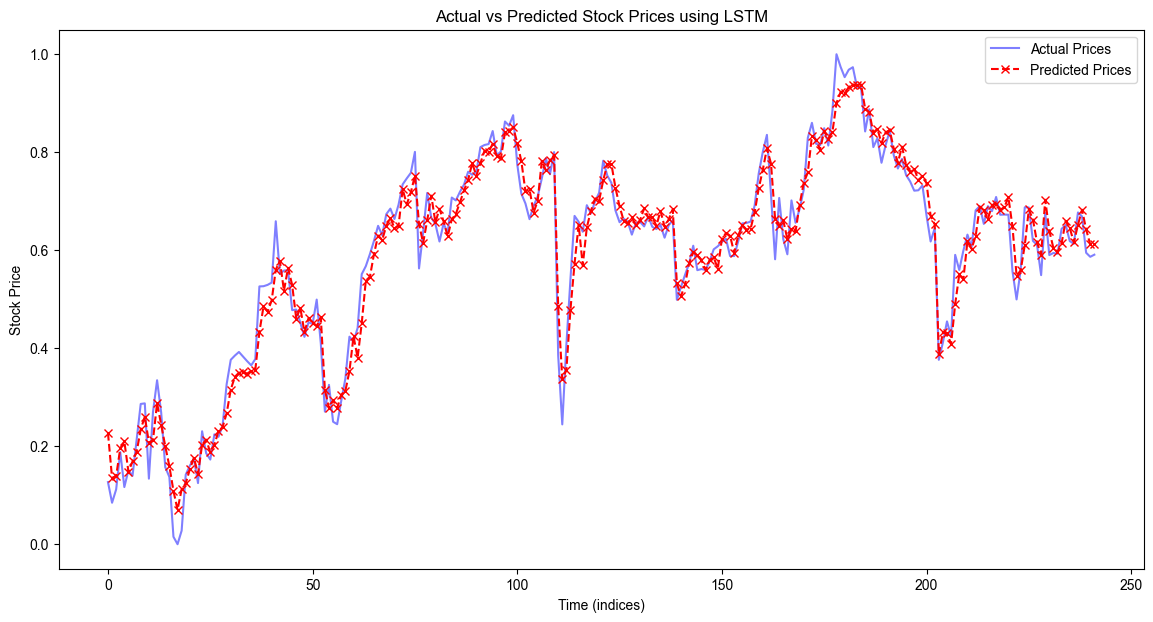

In [20]:
start_of_last_20_percent = int(len(Y_true) * 0.8)

# Generate indices for plotting
time_indices = np.arange(len(y_pred_all))

# Plotting
plt.figure(figsize=(14, 7))
plt.plot(time_indices, y, label='Actual Prices', color='blue', alpha=0.5)
# Overlay the predicted prices on the last 20%
plt.plot(time_indices, y_pred_all, label='Predicted Prices', color='red', linestyle='--', marker='x')

plt.title('Actual vs Predicted Stock Prices using LSTM')
plt.xlabel('Time (indices)')
plt.ylabel('Stock Price')
plt.legend()

In [21]:
from sklearn import metrics
print('Model accuracy (%)')

Y_true = y
Y_predicted = y_pred_all
print((1-(metrics.mean_absolute_error(Y_true, Y_predicted)/Y_true.mean()))*100)
print('')
print('Prediction performance')
print('MAE in %', (metrics.mean_absolute_error(Y_true, Y_predicted)/Y_true.mean())*100)
print('MSE', metrics.mean_squared_error(Y_true, Y_predicted))
print('RMSE',np.sqrt(metrics.mean_squared_error(Y_true, Y_predicted)))
print('R2', metrics.r2_score(Y_true, Y_predicted))

Model accuracy (%)
94.75723200504942

Prediction performance
MAE in % 5.242767994950579
MSE 0.00154415202941184
RMSE 0.039295699884489145
R2 0.964592302907678


**Another data preprocessiong Method: Time-Sensitive Data Augmentation Method**

Reference: https://www.hindawi.com/journals/complexity/2020/6737951/



**Random Forest Algorithm**


In [22]:
pip install PyWavelets

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


/tmp/ipykernel_13234/1531435118.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_stock_data.loc[:, columns + '2'] = recomposed_series[:len(recomposed_series)-1]
/tmp/ipykernel_13234/1531435118.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_stock_data.loc[:, columns + '2'] = recomposed_series[:len(recomposed_series)-1]
/tmp/ipykernel_13234/1531435118.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_in

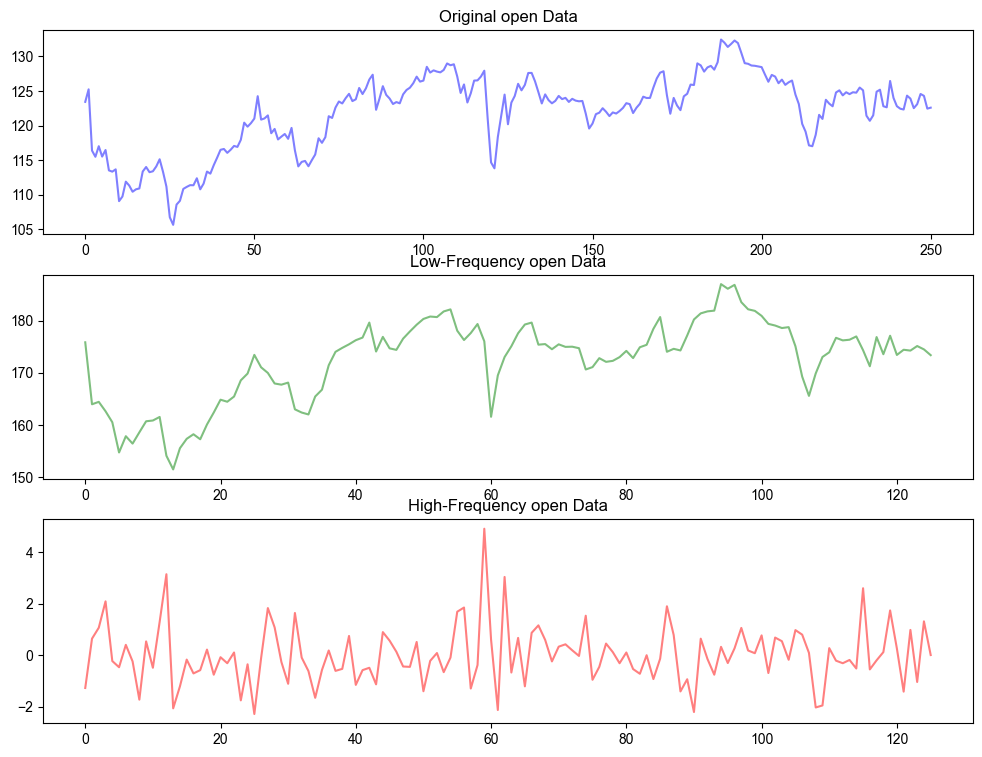

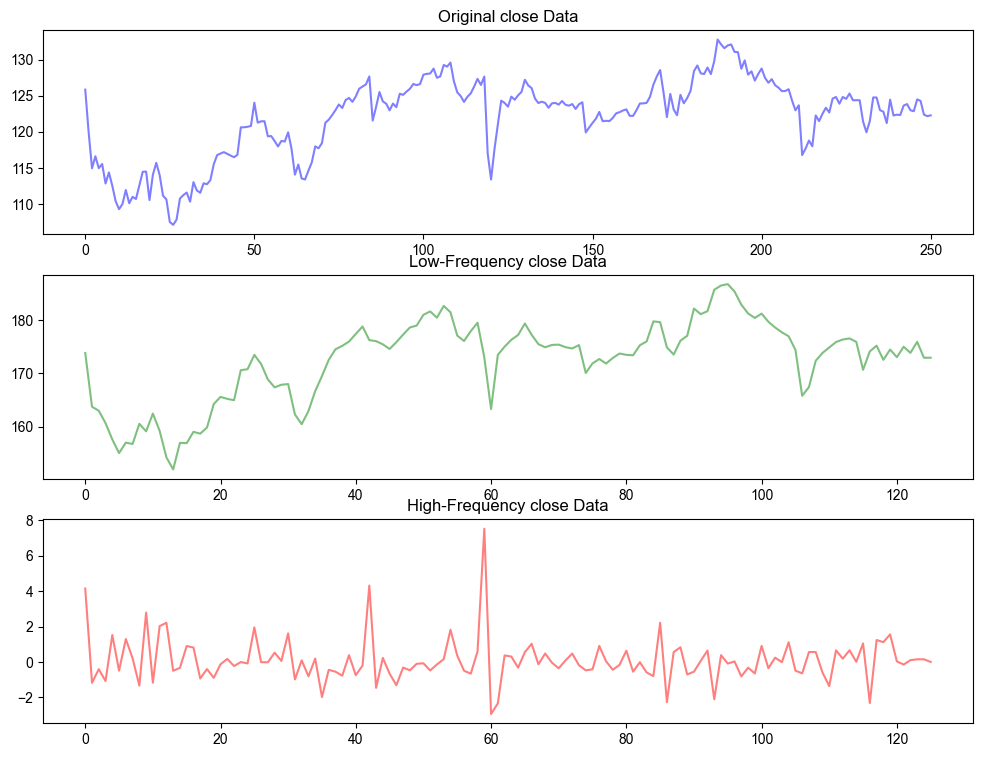

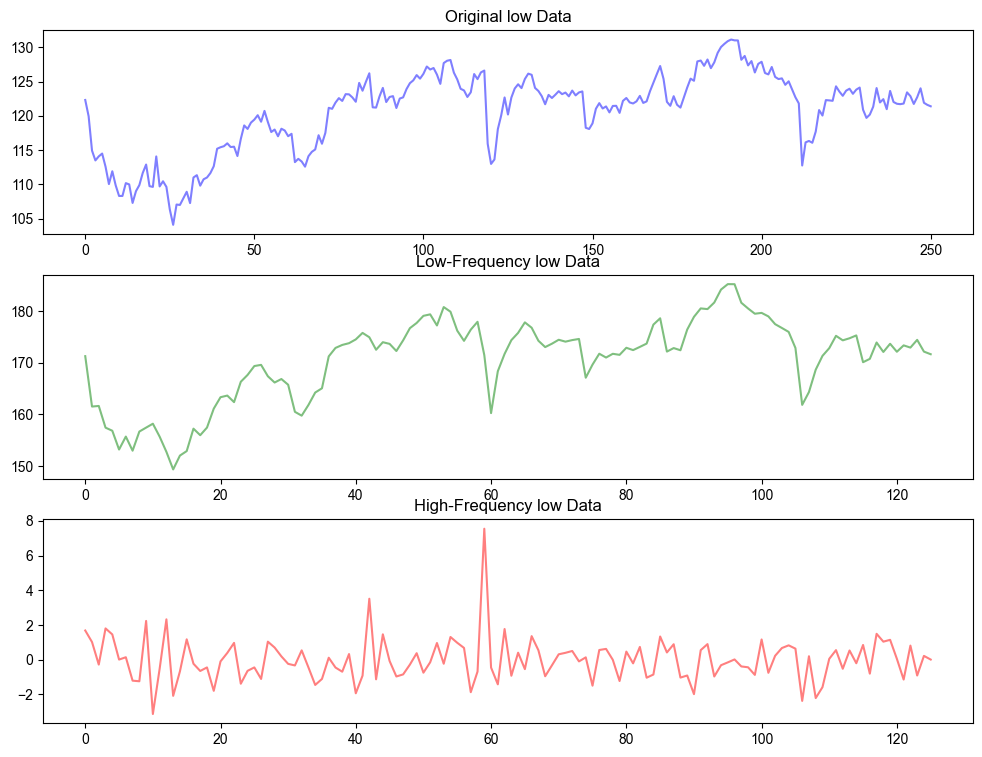

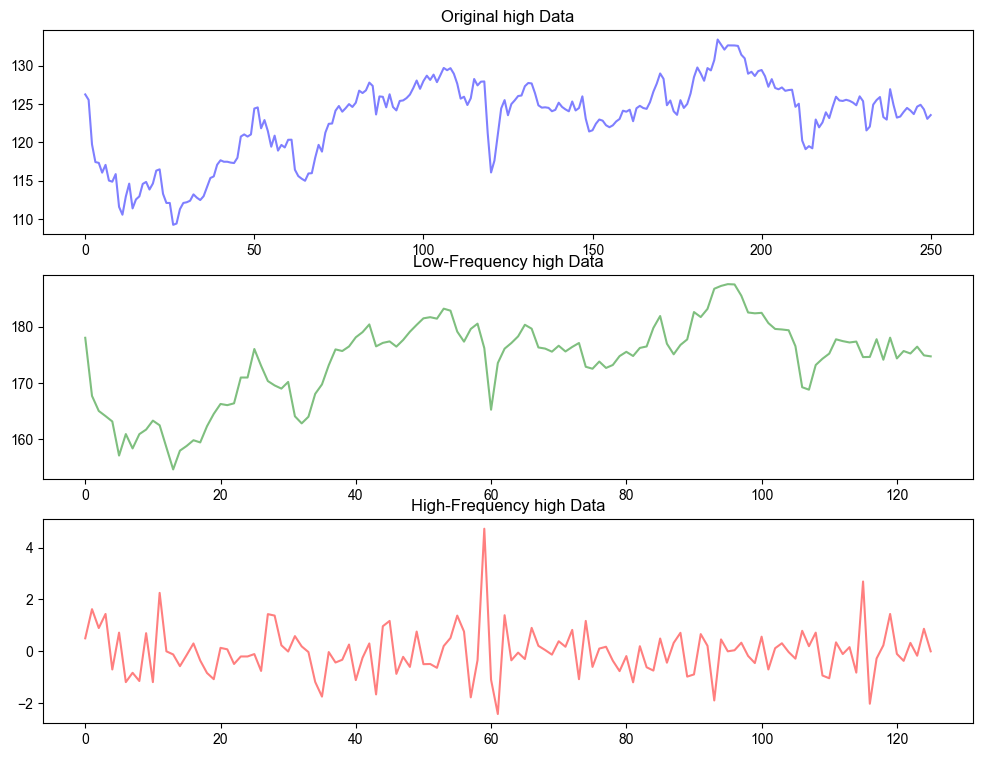

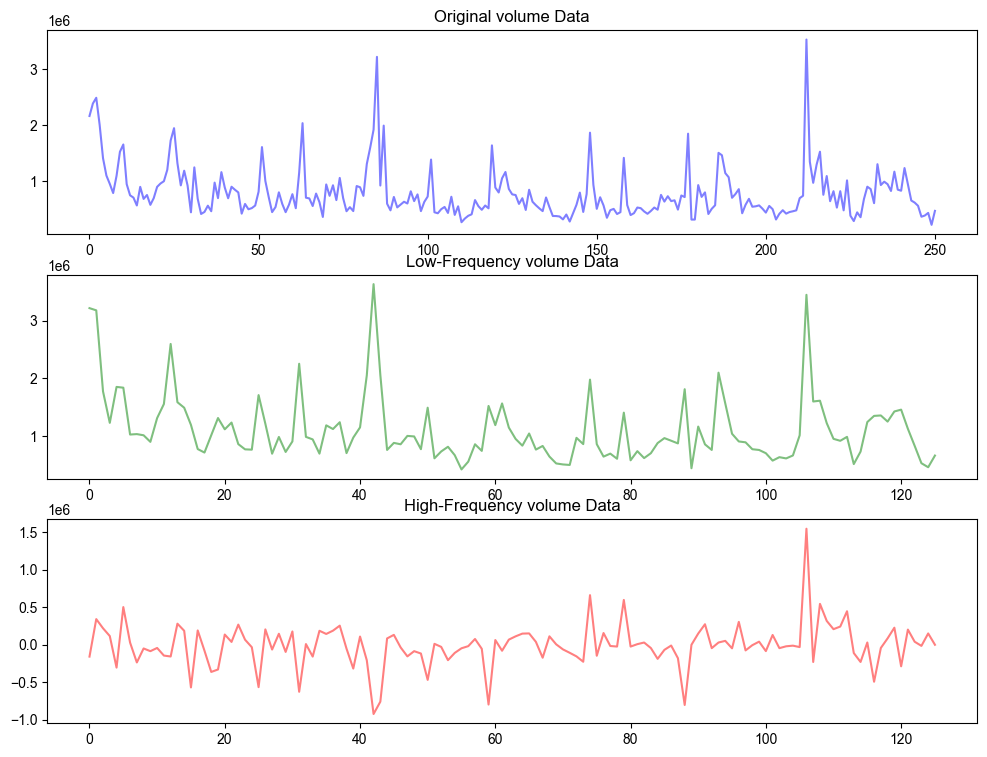

In [23]:
from scipy.signal import detrend
import pywt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

elected_symbol = prices_split_adjusted['symbol'].unique()[0]  # Example: 'WLTW'
selected_stock_data = prices_split_adjusted[prices_split_adjusted['symbol'] == selected_symbol]
# Decompose using discrete wavelet transform (DWT)
wavelet = 'db1'  # Daubechies wavelet

#Iterate over each columns
for columns in selected_stock_data.columns:
    if columns == 'data' or columns == 'symbol':
        continue

    data = selected_stock_data[columns].values
    low_freq,high_freq = pywt.dwt(data, wavelet)
    
    fig, axs = plt.subplots(3, 1, figsize=(12, 9))  # 3 subplots in a single column
    
    # Original data plot
    axs[0].plot(np.arange(len(data)), data, color='blue', alpha=0.5)
    axs[0].set_title(f'Original {columns} Data')

    
    # Low-frequency data plot
    axs[1].plot(np.arange(len(low_freq)), low_freq, color='green', alpha=0.5)
    axs[1].set_title(f'Low-Frequency {columns} Data')

    # High-frequency data plot
    axs[2].plot(np.arange(len(high_freq)), high_freq, color='red', alpha=0.5)
    axs[2].set_title(f'High-Frequency {columns} Data')

    # Apply noise to high-frequency components (random noise)
    # adding the noises following the Gaussian distribution to the high-frequency components
    noise_factor = 0.01
    noise = np.random.normal(0, noise_factor * np.std(high_freq), len(high_freq))
    high_freq += noise
    
    
    #Unlike image or natural language data, time series such as stock price data are time sensitive. 
    # That is, the stock price at the current time point is closely related to that at short-time points rather than overdue time points. 
    # To tackle this problem, a decay factor  is introduced, which controls the scale of noises added to the data at different time points

    decay_factor = 0.1
    for j in range(len(high_freq)):
        high_freq[j] *= (1 - decay_factor) ** j
        
    recomposed_series = pywt.idwt(low_freq, high_freq, wavelet)
    
    selected_stock_data.loc[:, columns + '2'] = recomposed_series[:len(recomposed_series)-1]


In [24]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

    
# Normalize features
features = ['open', 'low', 'high', 'volume']
X = selected_stock_data[features].values
y = selected_stock_data['close'].values

min_vals = X.min(axis=0)
max_vals = X.max(axis=0)

ranges = max_vals - min_vals

ranges[ranges == 0] = 1

X = (X - min_vals) / ranges
y_min = np.min(y)
y_max = np.max(y)
y = (y - y_min) / (y_max - y_min)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

model = RandomForestRegressor(random_state=100)

param_grid = {
    'n_estimators': [100, 200, 300, 400, 500], # Number of trees in the forest
    'max_depth': [None, 10, 20], # Maximum depth of trees
    'min_samples_split': [2, 5, 10], # Minimum samples to split
    'min_samples_leaf': [1, 2, 4] # Minimum samples to be a leaf node
}

grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_squared_error', verbose=1)
grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best Negative MSE:", grid_search.best_score_)

best_model = grid_search.best_estimator_

y_pred = best_model.predict(X)



Fitting 5 folds for each of 135 candidates, totalling 675 fits
Best Parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Best Negative MSE: -0.0015512496842005079


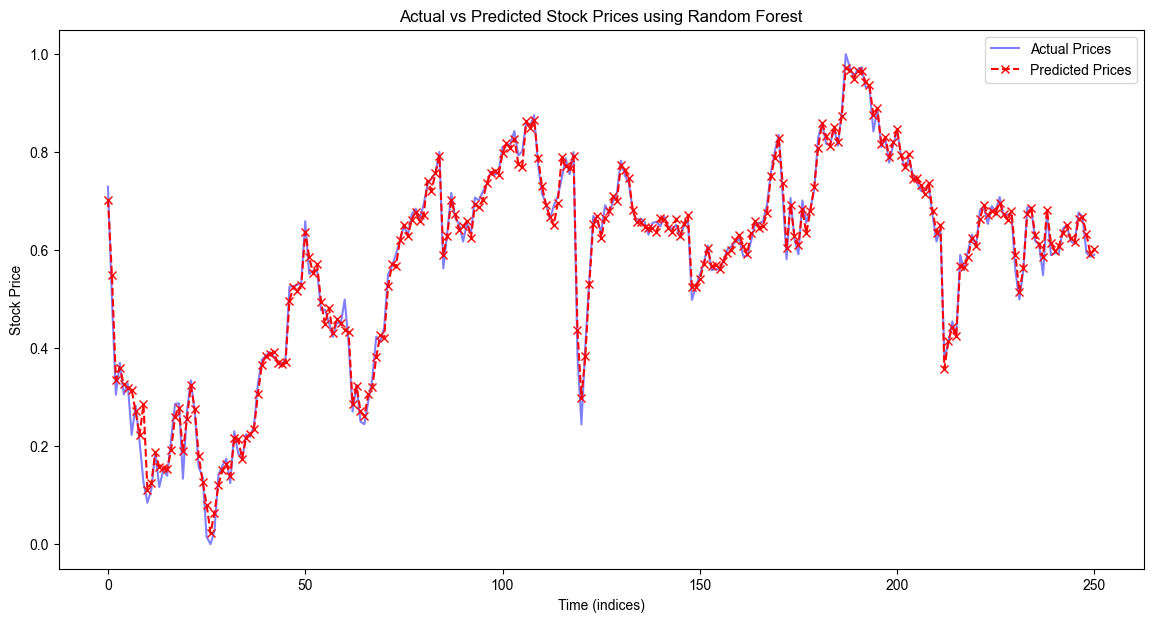

In [25]:
time_indices = np.arange(len(y))
start_of_last_20_percent = int(len(y) * 0.85)

# Plotting
plt.figure(figsize=(14, 7))
plt.plot(time_indices, y, label='Actual Prices', color='blue', alpha=0.5)
# Overlay the predicted prices on the last 20%
plt.plot(time_indices, y_pred, label='Predicted Prices', color='red', linestyle='--', marker='x')

plt.title('Actual vs Predicted Stock Prices using Random Forest')
plt.xlabel('Time (indices)')
plt.ylabel('Stock Price')
plt.legend()
plt.show()


In regression problems, we predict continuous numerical values rather than discrete class labels. 
**Accuracy, which measures the percentage of correct predictions out of the total predictions, is not suitable for regression tasks 
because it does not make sense to classify continuous predictions as correct or incorrect.** 
Instead, regression tasks commonly use evaluation metrics such as **Mean Squared Error (MSE), Mean Absolute Error (MAE), Root Mean Squared Error (RMSE), and R-squared (R2)** to assess the performance of the model in predicting continuous outcomes. These metrics provide insights into the model's prediction errors and how well it fits the data. Therefore, accuracy is not applicable in regression problems due to the nature of continuous predictions.

In [26]:
from sklearn import metrics
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

y_pred = best_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print((1-(metrics.mean_absolute_error(y_test, y_pred)/y_test.mean()))*100)
print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error % (MAE):", (metrics.mean_absolute_error(y_test, y_pred)/y_test.mean())*100)
print("Root Mean Squared Error (RMSE):", rmse)
print("R-squared (R2):", r2)


94.4394633785091
Mean Squared Error (MSE): 0.001649838835182869
Mean Absolute Error % (MAE): 5.560536621490897
Root Mean Squared Error (RMSE): 0.04061820817297175
R-squared (R2): 0.9720376220641399


**Support vector Machine algorithm (Supervised) with Sigmoid Kernel**

In [27]:
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)
model = SVR(kernel='sigmoid')

model.fit(X_train, y_train)

# Predict with the model
y_pred = model.predict(X_test)

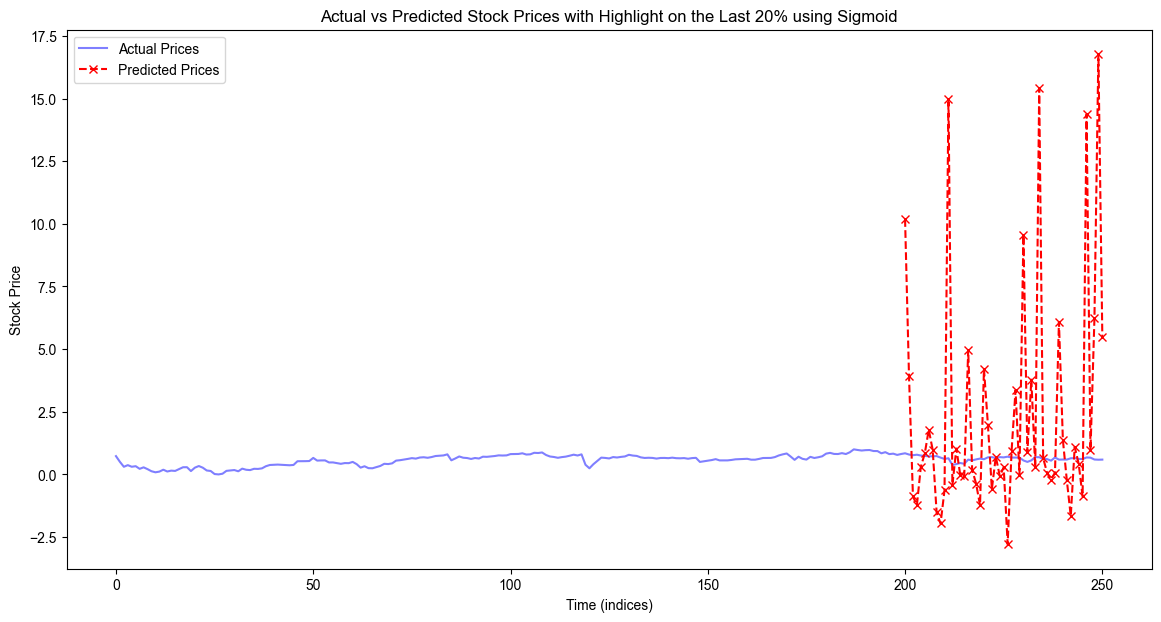

In [28]:
# Calculate the range for the last 20% of the data
# Assuming 'y' is your full set of actual prices (combining y_train and y_test appropriately if needed)
start_of_last_20_percent = int(len(y) * 0.8)
last_20 = len(y) - len(y_pred)

# Generate indices for plotting
time_indices = np.arange(len(y))
# Plotting
plt.figure(figsize=(14, 7))
plt.plot(time_indices, y, label='Actual Prices', color='blue', alpha=0.5)
# Overlay the predicted prices on the last 20%
plt.plot(time_indices[last_20:], y_pred, label='Predicted Prices', color='red', linestyle='--', marker='x')

plt.title('Actual vs Predicted Stock Prices with Highlight on the Last 20% using Sigmoid')
plt.xlabel('Time (indices)')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [29]:
from sklearn import metrics
print('Model accuracy (%)')

y_true = y[last_20:]

print((1-(metrics.mean_absolute_error(y_true, y_pred)/y_true.mean()))*100)
print('')
print('Prediction performance')
print('MAE in %', (metrics.mean_absolute_error(y_true, y_pred)/y_true.mean())*100)
print('MSE', metrics.mean_squared_error(y_true, y_pred))
print('RMSE',np.sqrt(metrics.mean_squared_error(y_true, y_pred)))
print('R2', metrics.r2_score(y_true, y_pred))


Model accuracy (%)
-346.6658713816746

Prediction performance
MAE in % 446.6658713816746
MSE 24.32407597582928
RMSE 4.931944441681119
R2 -2788.50871924054
